<a href="https://colab.research.google.com/github/reponseashimwe/linear_regression_model/blob/main/summative/linear_regression/multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Insurance Cost Prediction

 This notebook develops a predictive model to estimate individual medical insurance costs based on demographic and lifestyle factors.
 We'll compare Linear Regression, Decision Tree, and Random Forest models to determine which provides the most accurate predictions.

 ## Dataset Description

 The dataset used is the "Medical Cost Personal Datasets" from Kaggle. It contains information about medical insurance beneficiaries including demographic data, lifestyle factors, and the charges they incurred.

 ### Features:
 - **age**: Age of the primary beneficiary (numeric)
 - **sex**: Gender of the insurance contractor (female, male)
 - **bmi**: Body mass index (weight in kg / height in m²)
 - **children**: Number of dependents covered by health insurance (numeric)
 - **smoker**: Smoking status (yes, no)
 - **region**: Beneficiary's residential area in the US (northeast, southeast, southwest, northwest)
 - **charges**: Individual medical costs billed by health insurance (numeric, target variable)


In [13]:
# Import necessary libraries and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pickle
import warnings

# from google.colab import drive
# drive.mount('/content/drive')
# filename = "/content/drive/My Drive/notebook_data/insurance.csv"
filename = "insurance.csv"


# Set the style for visualizations
plt.style.use('ggplot')
sns.set(font_scale=1)

# Suppress warnings
warnings.filterwarnings("ignore")

### 2. Dataset Loading and Summary

In [14]:
# Load the dataset
data = pd.read_csv(filename)

# Display basic information about the dataset
print("Dataset Information:")
print(f"Number of rows: {data.shape[0]}")
print(f"Number of columns: {data.shape[1]}")

# Display the first few rows
print("\nFirst 5 rows:")
print(data.head())

# Statistical summary of the dataset
print("\nStatistical Summary:")
print(data.describe())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

Dataset Information:
Number of rows: 1338
Number of columns: 7

First 5 rows:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Statistical Summary:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000

## Exploratory Data Analysis

Let's explore the dataset to understand the distributions and relationships between variables.

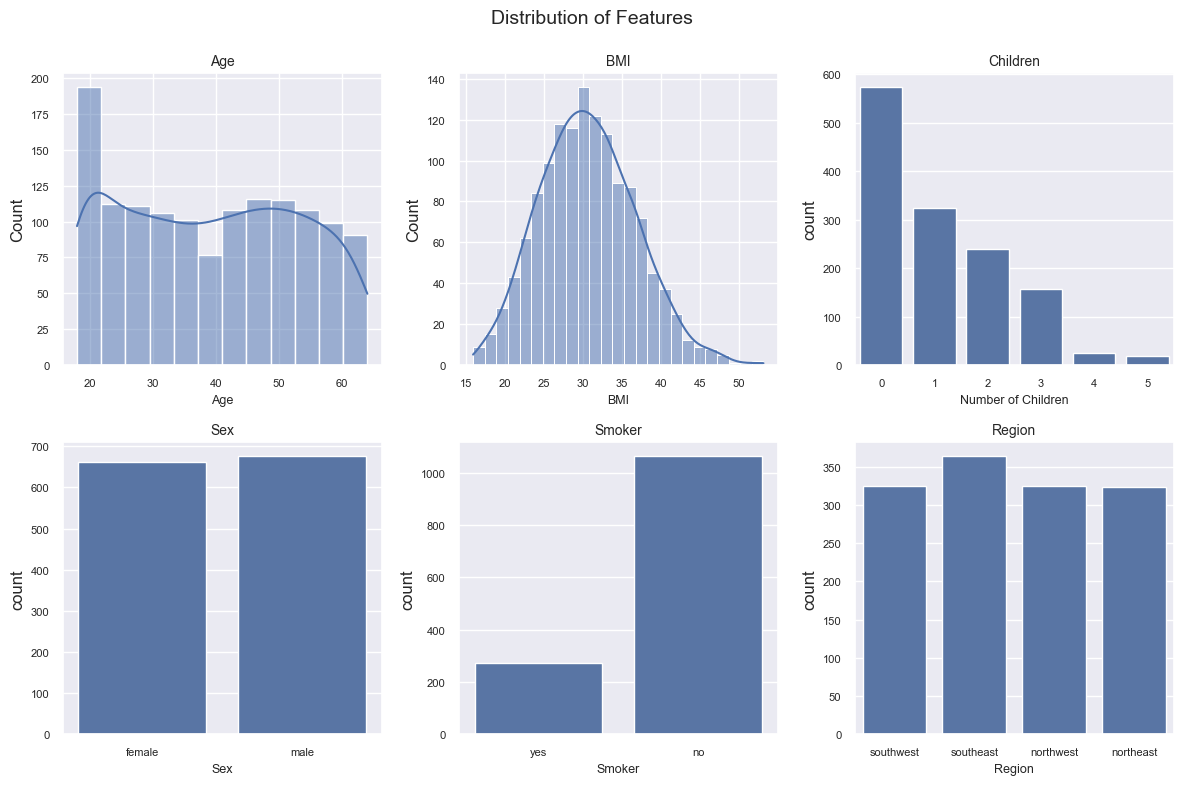

In [15]:
# Visualization 1: Distribution of Features in a 3x2 grid layout
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Distribution of Features', fontsize=14)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Age distribution
sns.histplot(data['age'], kde=True, ax=axes[0])
axes[0].set_title('Age', fontsize=10)
axes[0].set_xlabel('Age', fontsize=9)
axes[0].tick_params(labelsize=8)

# BMI distribution
sns.histplot(data['bmi'], kde=True, ax=axes[1])
axes[1].set_title('BMI', fontsize=10)
axes[1].set_xlabel('BMI', fontsize=9)
axes[1].tick_params(labelsize=8)

# Children distribution
sns.countplot(x='children', data=data, ax=axes[2])
axes[2].set_title('Children', fontsize=10)
axes[2].set_xlabel('Number of Children', fontsize=9)
axes[2].tick_params(labelsize=8)

# Sex distribution
sns.countplot(x='sex', data=data, ax=axes[3])
axes[3].set_title('Sex', fontsize=10)
axes[3].set_xlabel('Sex', fontsize=9)
axes[3].tick_params(labelsize=8)

# Smoker distribution
sns.countplot(x='smoker', data=data, ax=axes[4])
axes[4].set_title('Smoker', fontsize=10)
axes[4].set_xlabel('Smoker', fontsize=9)
axes[4].tick_params(labelsize=8)

# Region distribution
sns.countplot(x='region', data=data, ax=axes[5])
axes[5].set_title('Region', fontsize=10)
axes[5].set_xlabel('Region', fontsize=9)
axes[5].tick_params(labelsize=8)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Interpretation of Feature Distributions

- **Age**: The age distribution appears to be relatively uniform across the range, with slightly more individuals in the 18-25 age range.
- **BMI**: The BMI distribution follows a normal curve centered around 30, which is in the overweight range.
- **Children**: Most beneficiaries have 0 or 1 child, with fewer having 2 or more children.
- **Sex**: The dataset has a roughly equal distribution of males and females.
- **Smoker**: The majority of individuals in the dataset are non-smokers.
- **Region**: The four regions appear to be roughly equally represented in the dataset.

## Correlation Heat map

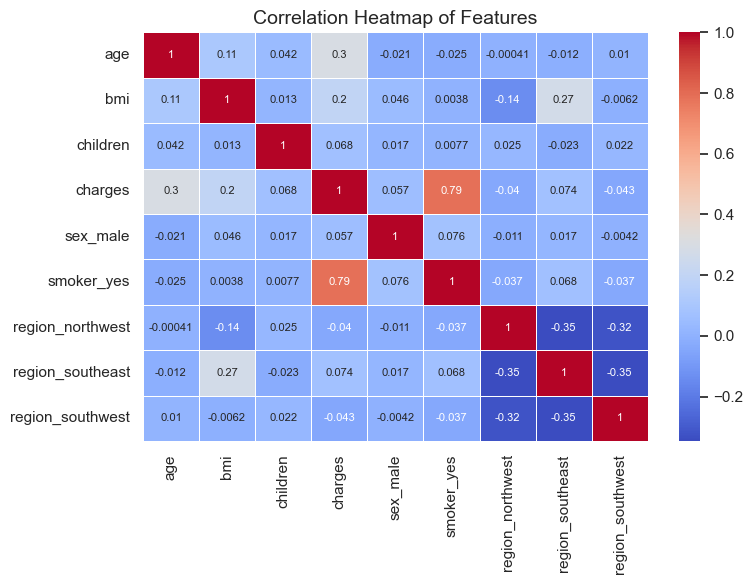

In [16]:
# Visualization 2: Correlation Heatmap
data_encoded = pd.get_dummies(data, columns=['sex', 'smoker', 'region'], drop_first=True)

# Visualization 2: Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation_matrix = data_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})
plt.title('Correlation Heatmap of Features', fontsize=14)
plt.tight_layout()
plt.show()

### Interpretation of Correlation Heatmap

The correlation heatmap reveals several important relationships:

- **Smoker Status**: Being a smoker has the strongest positive correlation with insurance charges. This suggests that smoking significantly increases medical costs.
- **Age**: Age shows a moderate positive correlation with charges, indicating that older individuals tend to have higher medical costs.
- **BMI**: BMI has a weaker positive correlation with charges, but it still suggests that higher BMI is associated with higher costs.
- **Children**: The number of children has a weak correlation with charges.
- **Region and Sex**: These variables show very weak correlations with the charges.


### Pairplot of numerical features

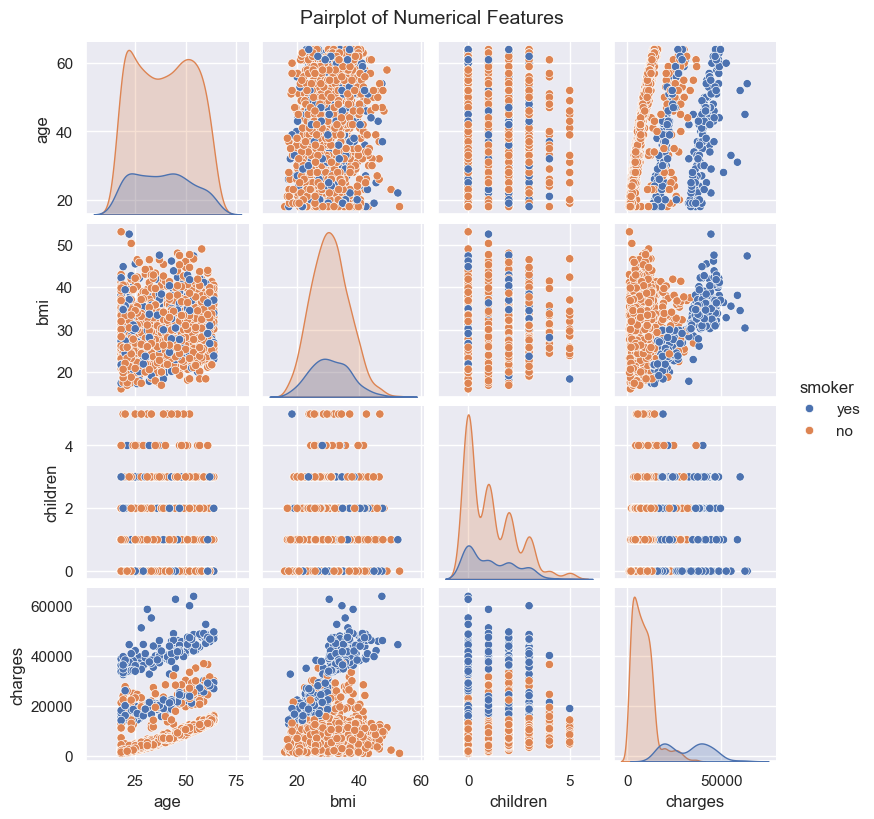

In [17]:
# Visualization 3: Pairplot of numerical features
sns.pairplot(data, vars=['age', 'bmi', 'children', 'charges'], hue='smoker', height=2)
plt.suptitle('Pairplot of Numerical Features', y=1.02, fontsize=14)
plt.show()

#### Interpretation of Pairplot

The pairplot provides insights into the relationships between numerical variables, with data points colored by smoking status:

- **Charges vs Age**: There's a positive trend, but with two distinct patterns. Smokers (orange) have significantly higher charges across all age groups compared to non-smokers (blue).
- **Charges vs BMI**: For non-smokers, BMI has little impact on charges. However, for smokers, there's a strong positive correlation between BMI and charges, suggesting that the combination of smoking and high BMI significantly increases medical costs.
- **Charges vs Children**: The relationship is less clear, but smokers consistently have higher charges regardless of how many children they have.
- **Age vs BMI**: There doesn't appear to be a strong correlation between age and BMI.

This visualization demonstrates that smoking status is a critical factor that interacts with other variables (particularly BMI) to influence insurance charges.

###  Boxplot for charges by categorical variables

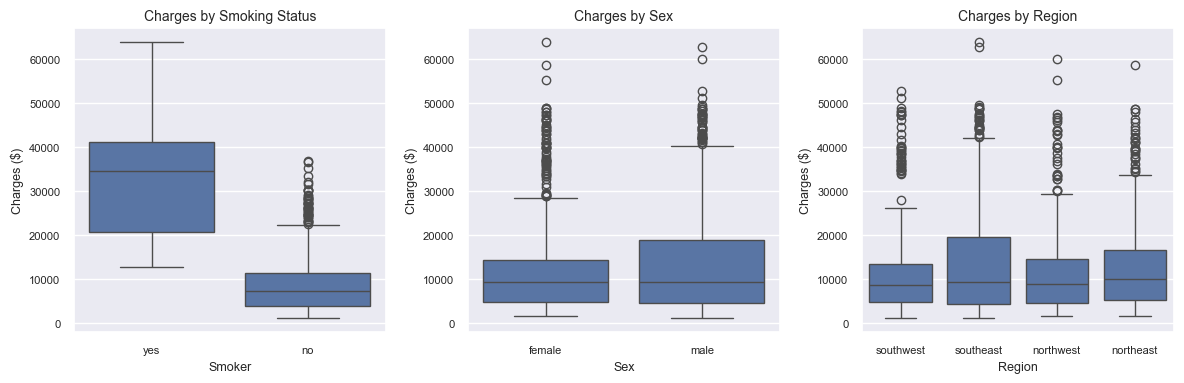

In [19]:
# Visualization 4: Boxplot for charges by categorical variables
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Charges by smoking status
sns.boxplot(x='smoker', y='charges', data=data, ax=axes[0])
axes[0].set_title('Charges by Smoking Status', fontsize=10)
axes[0].set_ylabel('Charges ($)', fontsize=9)
axes[0].set_xlabel('Smoker', fontsize=9)
axes[0].tick_params(labelsize=8)

# Charges by sex
sns.boxplot(x='sex', y='charges', data=data, ax=axes[1])
axes[1].set_title('Charges by Sex', fontsize=10)
axes[1].set_ylabel('Charges ($)', fontsize=9)
axes[1].set_xlabel('Sex', fontsize=9)
axes[1].tick_params(labelsize=8)

# Charges by region
sns.boxplot(x='region', y='charges', data=data, ax=axes[2])
axes[2].set_title('Charges by Region', fontsize=10)
axes[2].set_ylabel('Charges ($)', fontsize=9)
axes[2].set_xlabel('Region', fontsize=9)
axes[2].tick_params(labelsize=8)

plt.tight_layout()
plt.show()


### Interpretation of Boxplots

The boxplots provide a clear view of how charges vary across different categorical variables:

- **Smoking Status**: The most dramatic difference is seen here. Smokers have significantly higher median charges and a much wider range of charges compared to non-smokers. This reinforces our earlier finding that smoking is the strongest predictor of high insurance costs.
- **Sex**: There's not a substantial difference in charges between males and females, though males have a slightly higher median.
- **Region**: Charges are fairly consistent across regions, with the southeast showing a slightly higher median cost.

## Modeling

In [21]:
# Prepare data for modeling
X = data_encoded.drop('charges', axis=1)
y = data_encoded['charges']

# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# List to store models and their performances
models = []
test_mse_scores = []
train_mse_scores = []

# 1. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)
lr_train_mse = mean_squared_error(y_train, lr_train_pred)
lr_test_mse = mean_squared_error(y_test, lr_test_pred)
models.append(('Linear Regression', lr_model))
train_mse_scores.append(lr_train_mse)
test_mse_scores.append(lr_test_mse)

print("\nLinear Regression Results:")
print(f"Training MSE: {lr_train_mse:.2f}")
print(f"Testing MSE: {lr_test_mse:.2f}")
print(f"R² Score: {lr_model.score(X_test, y_test):.4f}")

# 2. Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
dt_train_pred = dt_model.predict(X_train)
dt_test_pred = dt_model.predict(X_test)
dt_train_mse = mean_squared_error(y_train, dt_train_pred)
dt_test_mse = mean_squared_error(y_test, dt_test_pred)
models.append(('Decision Tree', dt_model))
train_mse_scores.append(dt_train_mse)
test_mse_scores.append(dt_test_mse)

print("\nDecision Tree Results:")
print(f"Training MSE: {dt_train_mse:.2f}")
print(f"Testing MSE: {dt_test_mse:.2f}")
print(f"R² Score: {dt_model.score(X_test, y_test):.4f}")

# 3. Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)
rf_train_mse = mean_squared_error(y_train, rf_train_pred)
rf_test_mse = mean_squared_error(y_test, rf_test_pred)
models.append(('Random Forest', rf_model))
train_mse_scores.append(rf_train_mse)
test_mse_scores.append(rf_test_mse)

print("\nRandom Forest Results:")
print(f"Training MSE: {rf_train_mse:.2f}")
print(f"Testing MSE: {rf_test_mse:.2f}")
print(f"R² Score: {rf_model.score(X_test, y_test):.4f}")


Training set shape: (1070, 8)
Testing set shape: (268, 8)

Linear Regression Results:
Training MSE: 37277681.70
Testing MSE: 33596915.85
R² Score: 0.7836

Decision Tree Results:
Training MSE: 244239.55
Testing MSE: 42446908.01
R² Score: 0.7266

Random Forest Results:
Training MSE: 3753332.49
Testing MSE: 20942520.92
R² Score: 0.8651


## MSE Comparison for Models

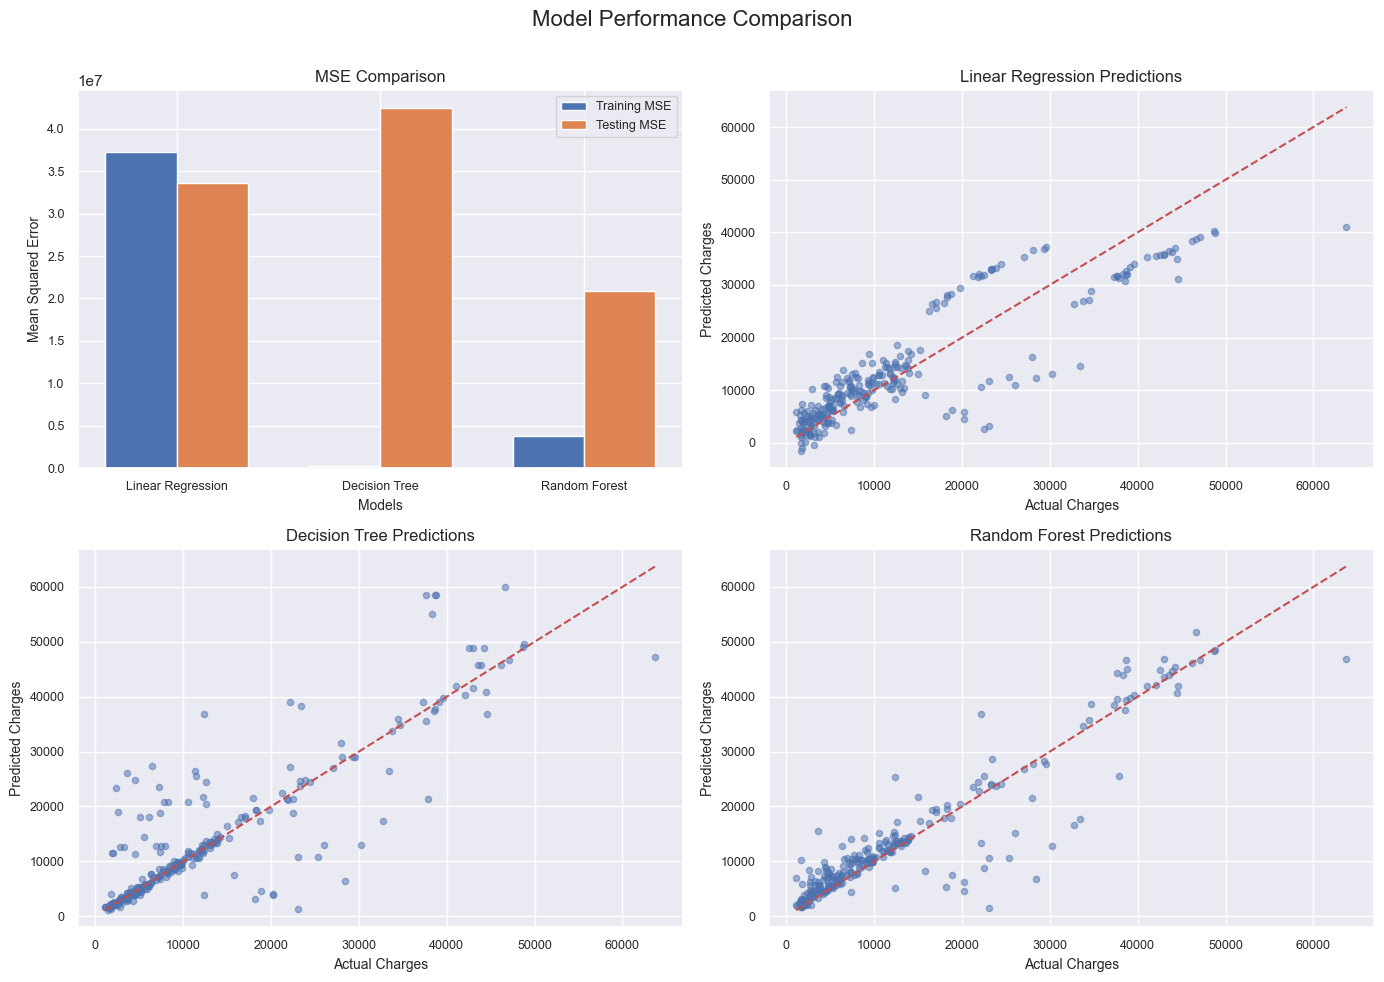

In [22]:
# Visualization 5 & 6: Combined MSE Comparison and Predictions vs Actual Values for all models
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

# MSE Comparison Bar Chart (top left)
model_names = ['Linear Regression', 'Decision Tree', 'Random Forest']
bar_width = 0.35
x = np.arange(len(model_names))

axes[0, 0].bar(x - bar_width/2, train_mse_scores, bar_width, label='Training MSE')
axes[0, 0].bar(x + bar_width/2, test_mse_scores, bar_width, label='Testing MSE')
axes[0, 0].set_xlabel('Models', fontsize=10)
axes[0, 0].set_ylabel('Mean Squared Error', fontsize=10)
axes[0, 0].set_title('MSE Comparison', fontsize=12)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(model_names, fontsize=9)
axes[0, 0].tick_params(axis='y', labelsize=9)
axes[0, 0].legend(fontsize=9)

# Predictions vs Actual scatter plots (top right and bottom)
model_preds = [lr_test_pred, dt_test_pred, rf_test_pred]
plot_positions = [(0, 1), (1, 0), (1, 1)]  # positions in the 2x2 grid

for i, ((name, _), pos) in enumerate(zip(models, plot_positions)):
    row, col = pos
    axes[row, col].scatter(y_test, model_preds[i], alpha=0.5, s=20)
    axes[row, col].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[row, col].set_title(f'{name} Predictions', fontsize=12)
    axes[row, col].set_xlabel('Actual Charges', fontsize=10)
    axes[row, col].set_ylabel('Predicted Charges', fontsize=10)
    axes[row, col].tick_params(labelsize=9)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Identify the best model based on test MSE
best_model_index = np.argmin(test_mse_scores)
best_model_name, best_model = models[best_model_index]
best_model_predictions = best_model.predict(X_test)

### Interpretation of MSE Comparison

The MSE (Mean Squared Error) comparison reveals important differences between the models:

- **Linear Regression**: Shows similar MSE values for both training and testing data, indicating that it's not overfitting. However, its overall error is relatively high compared to the tree-based models, suggesting that it may be underfitting due to its inability to capture non-linear relationships in the data.

- **Decision Tree**: Has an extremely low training MSE (near zero) but a significantly higher testing MSE, which is a classic sign of overfitting. The model performs perfectly on the training data by essentially memorizing it, but doesn't generalize well to unseen data.

- **Random Forest**: Has a low training MSE (though not as low as the decision tree) and the lowest testing MSE among all three models. This indicates that the Random Forest achieves the best balance between fitting the training data and generalizing to new data.

The Random Forest model is the clear winner in terms of predictive performance on unseen data.


 ### Interpretation of Prediction Plots
These scatter plots show how well each model's predictions match the actual values:

- **Linear Regression**: Shows a linear pattern of predictions, but with significant scatter, especially for higher charges. The model tends to underestimate very high charges, indicating it cannot fully capture the factors that lead to extremely high insurance costs.

- **Decision Tree**: Shows a step-like pattern of predictions, which is characteristic of decision trees. This occurs because the model makes discrete splits in the data. While some predictions are very accurate, others show large deviations from the actual values.
- **Random Forest**: Shows the tightest clustering around the ideal line (red dashed line), indicating the best overall predictive performance. It avoids the step-like pattern of the decision tree by averaging predictions from multiple trees, resulting in smoother and more accurate predictions across the range of charges.

The Random Forest model clearly demonstrates superior performance in accurately predicting insurance charges across the entire range of values.


In [23]:
best_model_index = np.argmin(test_mse_scores)
best_model_name, best_model = models[best_model_index]
best_model_predictions = best_model.predict(X_test)
features = [col for col in X_test.columns]

# Feature importance for Random Forest
if best_model_name == 'Random Forest' or best_model_name == 'Decision Tree':
    feature_importance = pd.DataFrame({'Feature': features, 'Importance': best_model.feature_importances_})
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    # Print top features with percentages
    print(f"\nTop 3 Important Features from {best_model_name}:")
    total_importance = sum(feature_importance['Importance'][:3])  # Calculate total importance of top 3 features

    for i, (feature, importance) in enumerate(zip(feature_importance['Feature'][:3], feature_importance['Importance'][:3])):
        percentage = (importance / total_importance) * 100  # Calculate percentage importance
        print(f"{i+1}. {feature}: {importance:.4f} ({percentage:.2f}%)")

# Save only the best model
best_model_filename = 'best_model.pkl'
with open(best_model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"\nBest model ({best_model_name}) saved to {best_model_filename}")


Top 3 Important Features from Random Forest:
1. smoker_yes: 0.6086 (63.44%)
2. bmi: 0.2165 (22.57%)
3. age: 0.1342 (13.99%)

Best model (Random Forest) saved to best_model.pkl


In [16]:
best_model_predictions = best_model.predict(X_test)
print("\nTest Predictions with Actual vs Predicted Comparison:")
print("-" * 110)
print(f"{'Index':<7} {'Age':<5} {'Sex':<8} {'BMI':<8} {'Children':<10} {'Smoker':<8} {'Region':<10} {'Actual Cost':<15} {'Predicted Cost':<15} {'Difference %':<15}")
print("-" * 110)

# Get original X_test data with corresponding features
X_test_with_features = pd.concat([X_test.reset_index(drop=True), pd.DataFrame({'pred': best_model_predictions})], axis=1)

# Map the encoded features back to original values
X_test_with_features['sex'] = ['male' if row['sex_male'] == 1 else 'female' for _, row in X_test_with_features.iterrows()]
X_test_with_features['smoker'] = ['yes' if row['smoker_yes'] == 1 else 'no' for _, row in X_test_with_features.iterrows()]
X_test_with_features['region'] = [
    'northeast' if not any([row['region_northwest'], row['region_southeast'], row['region_southwest']]) else
    'northwest' if row['region_northwest'] == 1 else
    'southeast' if row['region_southeast'] == 1 else
    'southwest' if row['region_southwest'] == 1 else
    'unknown'
    for _, row in X_test_with_features.iterrows()
]

# Get actual y_test values
X_test_with_features['actual'] = y_test.reset_index(drop=True)

# Calculate difference percentage
X_test_with_features['diff_pct'] = abs((X_test_with_features['pred'] - X_test_with_features['actual']) / X_test_with_features['actual'] * 100)

# Select first, last, middle indices
first_index = X_test_with_features.index[0]
last_index = X_test_with_features.index[-1]
a100th_index = X_test_with_features.index[100]
a215th_index = X_test_with_features.index[215]
a175th_index = X_test_with_features.index[175]

sampled_indices = [first_index, last_index, a100th_index, a215th_index, a175th_index]

for idx in sampled_indices:
    row = X_test_with_features.iloc[idx]
    age = int(row['age'])
    sex = row['sex']
    bmi = row['bmi']
    children = int(row['children'])
    smoker = row['smoker']
    region = row['region']
    actual = row['actual']
    predicted = row['pred']
    diff_pct = row['diff_pct']

    print(f"{idx:<7} {age:<5} {sex:<8} {bmi:<8.1f} {children:<10} {smoker:<8} {region:<10} ${actual:<14.2f} ${predicted:<14.2f} {diff_pct:<14.2f}%")

print("-" * 110)


Test Predictions with Actual vs Predicted Comparison:
--------------------------------------------------------------------------------------------------------------
Index   Age   Sex      BMI      Children   Smoker   Region     Actual Cost     Predicted Cost  Difference %   
--------------------------------------------------------------------------------------------------------------
0       45    female   25.2     2          no       northeast  $9095.07        $9630.26        5.88          %
267     51    female   34.2     1          no       southwest  $9872.70        $9896.71        0.24          %
100     30    female   28.4     1          no       northwest  $4527.18        $4517.23        0.22          %
215     30    female   27.9     0          no       northeast  $4137.52        $4102.13        0.86          %
175     47    male     25.4     1          yes      southeast  $21978.68       $22883.18       4.12          %
---------------------------------------------------------

## Conclusions

From our analysis of the medical insurance cost dataset, we can draw several important conclusions:

1. **Best Predictive Model**: The Random Forest Regressor outperformed both Linear Regression and Decision Tree models, achieving the lowest Mean Squared Error on the test dataset. This superior performance is due to its ability to capture complex non-linear relationships while avoiding overfitting.
2. **Key Factors Affecting Insurance Costs**:
   - **Smoking Status**: By far the most important factor, with smokers incurring significantly higher costs.
  - **Age**: Older individuals tend to have higher insurance costs.
   - **BMI**: Higher body mass index is associated with increased costs, especially for smokers.
3. **Practical Implications**:
   - Individuals can potentially lower their insurance costs by maintaining a healthy lifestyle, particularly by not smoking and maintaining a healthy BMI.
   - Insurance providers can use these insights to better assess risk and set premiums.
   - Healthcare policymakers might consider these factors when designing preventive healthcare initiatives.

 4. **Model Limitations**:
    - There may be other important factors affecting insurance costs that aren't captured in this dataset.
    - The model might not generalize well to populations significantly different from those in the training data.

This analysis demonstrates the power of machine learning in predicting healthcare costs and identifying the key factors that influence these costs.
